## _Evaluation Metrics_

_If **GNNBuilder** callback has been run during training, just load data from `dnn_processed/test` and extract `scores` and `y_pid ~ truth` and simply run the following metrics_.

In [1]:
import sys, os, glob, yaml

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import torchmetrics
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# append parent dir
sys.path.append('..')

In [7]:
from src.metric_utils import compute_metrics, plot_metrics
from src.metric_utils import plot_roc, plot_prc, plot_prc_thr, plot_epc, plot_epc_cut, plot_output

### _Evaluation Definitions_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot


Use _`tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()`_ to directly access TN, FP, FN and TP using Scikit-learn.

### _Classifier Evaluation_

In [8]:
# DNN (Muons)
# inputdir = "run_all/dnn_processed_bn/pred"
# inputdir = "run_all/dnn_processed_ln/pred"

# GNN (Muons)
# inputdir = "run_all/gnn_processed/pred"

# HypGNN (FWP + No Filtering)
inputdir = "run_all/fwp_gnn_processed/pred"

In [9]:
outname = "fwp"

In [10]:
test_files = sorted(glob.glob(os.path.join(inputdir, "*")))
print("Number of Files: ", len(test_files))

Number of Files:  29703


In [11]:
# Let's test a event
data = torch.load(test_files[0], map_location=device)

In [12]:
data

Data(x=[24, 3], pid=[24], layers=[24], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000000', hid=[24], pt=[24], vertex=[24, 3], charge=[24], pdgcode=[24], ptheta=[24], peta=[24], pphi=[24], modulewise_true_edges=[2, 22], layerwise_true_edges=[2, 25], edge_index=[2, 44], y_pid=[44], scores=[88])

### _Append Scores and Truths_
- _Load all `truth` and `scores` from the `testset` from the `DNN` stage_

In [13]:
scoresl, truthsl = [], []

for e in range(len(test_files)):

    # read test events e.g. gnn_processed/test
    graph = torch.load(test_files[e], map_location=device)
    
    # get truths and scores
    truth = graph.y_pid
    score = graph.scores
    score = score[:truth.size(0)]

    # logging
    if e !=0 and (e)%1000==0:
        print("Processed Batches: ", e)
        
    # append each batch
    truthsl.append(truth)
    scoresl.append(score)

Processed Batches:  1000
Processed Batches:  2000
Processed Batches:  3000
Processed Batches:  4000
Processed Batches:  5000
Processed Batches:  6000
Processed Batches:  7000
Processed Batches:  8000
Processed Batches:  9000
Processed Batches:  10000
Processed Batches:  11000
Processed Batches:  12000
Processed Batches:  13000
Processed Batches:  14000
Processed Batches:  15000
Processed Batches:  16000
Processed Batches:  17000
Processed Batches:  18000
Processed Batches:  19000
Processed Batches:  20000
Processed Batches:  21000
Processed Batches:  22000
Processed Batches:  23000
Processed Batches:  24000
Processed Batches:  25000
Processed Batches:  26000
Processed Batches:  27000
Processed Batches:  28000
Processed Batches:  29000


In [14]:
scores = torch.cat(scoresl)
truths = torch.cat(truthsl)

In [15]:
# save scores and truths as .npy files
np.save(outname+"_scores.npy", scores.numpy())
np.save(outname+"_truths.npy", truths.numpy())

In [16]:
# torch to numpy
scores = scores.numpy()
truths = truths.numpy()

### _Compute Metrics_

In [17]:
metrics = compute_metrics(scores,truths,threshold=0.5)

In [18]:
print("{:.4f},{:.4f},{:.4f},{:.4f}".format(metrics.accuracy, metrics.precision, metrics.recall, metrics.f1))

0.9824,0.9735,0.9871,0.9803


### _(a) - Plot Metrics_

In [19]:
# plot_metrics(scores,truths, metrics, name=outname)

In [20]:
# ROC Curve
# plot_roc(metrics, name=outname)

In [21]:
# PR Curve
# plot_prc(metrics, name=outname)

In [22]:
# Built from PRC Curve
# plot_prc_thr(metrics, name=outname)

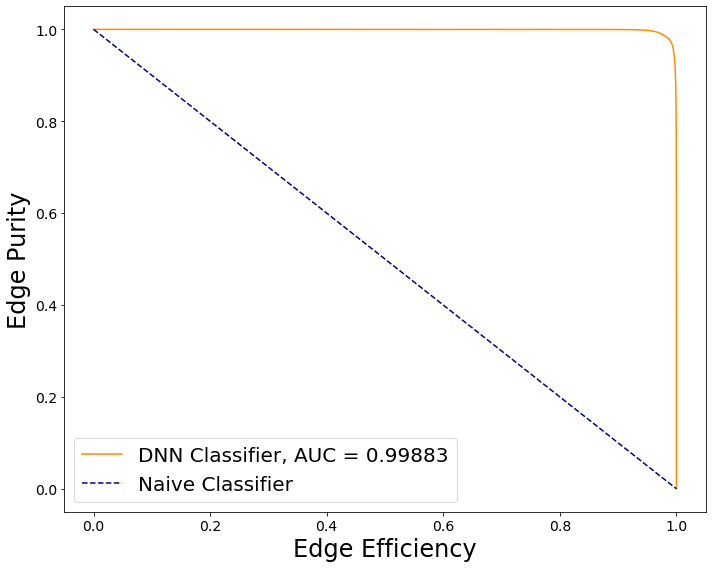

In [23]:
# EP Curve from ROC
plot_epc(metrics, name=outname)

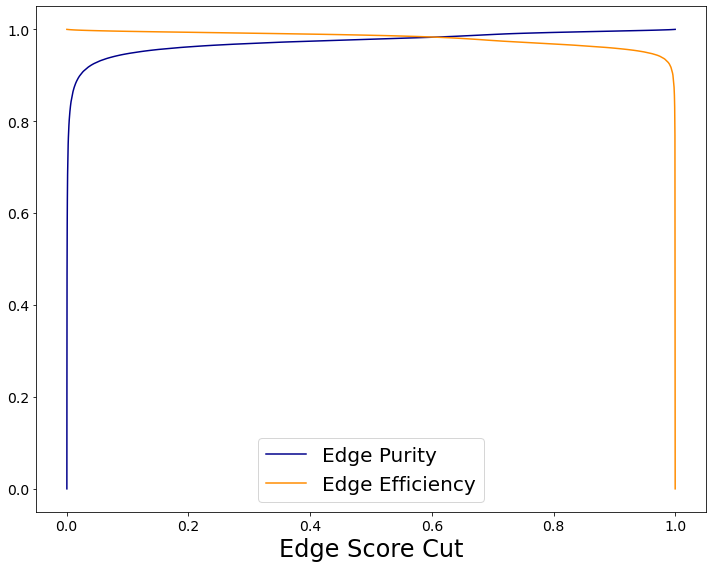

In [24]:
# Built from ROC Curve
plot_epc_cut(metrics, name=outname)

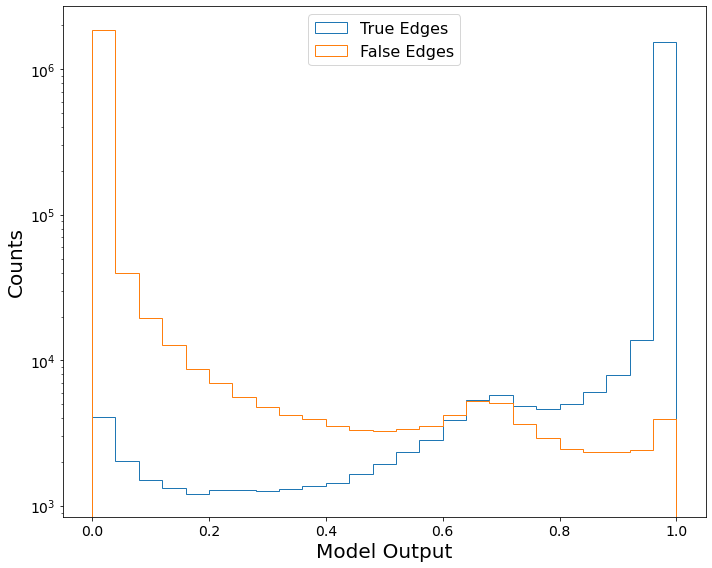

In [25]:
# Model output: True and False
plot_output(scores, truths, threshold=0.5, name=outname)

### _(b) - S/B Suppression_

Background rejection rate (1/FPR) is given as $1/\epsilon_{bkg}$ where $\epsilon_{bkg}$ is the fraction of fake edges that pass the classification requirement. Signal efficiency (TPR ~ Recall) ($\epsilon_{sig}$) is defined as the number of true edges above a given classification score cut over the total number of true edges. What we have?

- Signal Efficiency = $\epsilon_{sig}$ = TPR ~ Recall 
- Background Rejection = $1 - \epsilon_{bkg}$ ???
- Background Rejection Rate = $1/\epsilon_{bkg}$ = 1/FPR


First apply a edge score cut to binarized the `scores`, we will call it `preds`. The count number of false or true edges that pass this cut. Then calculated background rejection rate and signal efficiency. For making a plot one can do calculations in batch by batch mode on the test dataset.

In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
threshold = 0.7

- _recall/tpr and fpr_

In [45]:
preds, targets = scores, truths
y_pred, y_true = (preds > threshold), (targets > threshold)

In [46]:
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Find Recal/TPR and FPR
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

In [47]:
tpr, fpr

(0.975793902654237, 0.011099999950762952)

- **_edge efficiency vs edge purity_**

In [48]:
# edge efficiency (TPR), purity (1 - FPR)
print("edge efficiency: {:.4f}\n    edge purity: {:.4f}".format(tpr, (1-fpr)))

edge efficiency: 0.9758
    edge purity: 0.9889


- **_signal vs background rejection rate_**

In [49]:
# Signal efficiency (TPR), Bkg efficiency (FPR), Bkg Rejection (1/FPR)
print("     Signal efficiency: {:.4f}\nMisidentification rate: {:.4f}\n         bkg rejection: {:.4f}".format(tpr, fpr, (1/fpr)))

     Signal efficiency: 0.9758
Misidentification rate: 0.0111
         bkg rejection: 90.0901


- _plotting signal vs bkg rejection_

In [50]:
# Metrics with Threshold
metrics = compute_metrics(scores,truths,threshold)

In [51]:
# ROC Curve
sig = metrics.roc_tpr
bkg_rejection = 1/metrics.roc_fpr

/tmp/ipykernel_1817619/712045607.py:3: RuntimeWarning: divide by zero encountered in true_divide
  bkg_rejection = 1/metrics.roc_fpr


In [52]:
# cut off eff < 0.2 or 0.5
sig_mask = sig > 0.5

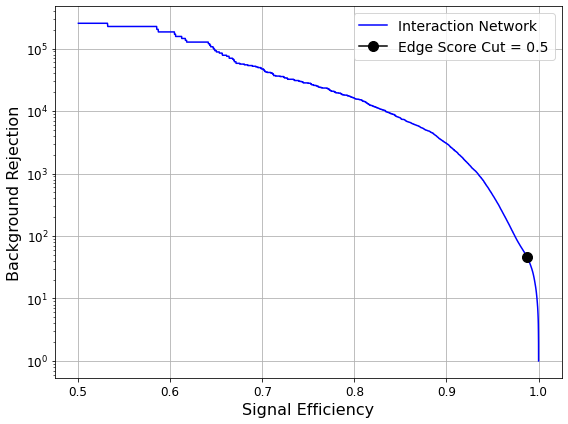

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(sig[sig_mask], bkg_rejection[sig_mask], label="Interaction Network", color="blue")
ax.plot(tpr, 1/fpr, marker="o", markersize=10, markeredgecolor="k", markerfacecolor="k", label="Edge Score Cut = 0.5", color="k")

# Axes Params
ax.set_xlabel("Signal Efficiency", fontsize=16)
ax.set_ylabel("Background Rejection", fontsize=16)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid(True)
ax.legend(fontsize=14, loc='upper right')
    
# Figure Params
fig.tight_layout()
fig.savefig(outname+"_SB.pdf")

### _(c) - Visualize Model Output_